<a href="https://colab.research.google.com/github/aksh-ai/image-super-resolution/blob/master/srgan_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
from math import log
from torch import nn
from PIL import Image
from IPython import display
from google.colab import drive
from torchvision import transforms 

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!nvidia-smi

Thu Jul  9 09:42:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
torch.cuda.empty_cache()

In [6]:
class ResidualBlock(nn.Module):
	def __init__(self, channels: int = None) -> None:
		super(ResidualBlock, self).__init__()

		self.block = nn.Sequential(nn.Conv2d(channels, channels, kernel_size=3, padding=1),
								nn.BatchNorm2d(channels),
								nn.PReLU(),
								nn.Conv2d(channels, channels, kernel_size=3, padding=1),
								nn.BatchNorm2d(channels))
	
	def forward(self, x: torch.Tensor) -> torch.Tensor:
		residual = self.block(x)
		return x + residual

In [7]:
class UpSample(nn.Module):
	def __init__(self, in_feat: int = None, upscale: int = None) -> None:
		super(UpSample, self).__init__()

		self.block = nn.Sequential(nn.Conv2d(in_feat, in_feat * upscale ** 2, kernel_size=3, padding=1),
								nn.PixelShuffle(upscale),
								nn.PReLU())
	
	def forward(self, x: torch.Tensor) -> torch.Tensor:
		return self.block(x)

In [8]:
class Generator(nn.Module):
	def __init__(self, scale_factor: int = None) -> None:
		super(Generator, self).__init__()
		
		num_upsamples = int(log(scale_factor, 2))
		
		self.conv_block1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=9, padding=4),
									nn.PReLU())
		
		self.conv_block2 = ResidualBlock(64)
		self.conv_block3 = ResidualBlock(64)
		self.conv_block4 = ResidualBlock(64)
		self.conv_block5 = ResidualBlock(64)
		self.conv_block6 = ResidualBlock(64)
		
		self.conv_block7 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1),
									nn.BatchNorm2d(64))

		upsample_blocks = [UpSample(64, 2) for _ in range(num_upsamples)]
		upsample_blocks.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))

		self.conv_block8 = nn.Sequential(*upsample_blocks)
	
	def forward(self, x: torch.Tensor) -> torch.Tensor:
		block1 = self.conv_block1(x)
		block2 = self.conv_block2(block1)
		block3 = self.conv_block3(block2)
		block4 = self.conv_block4(block3)
		block5 = self.conv_block5(block4)
		block6 = self.conv_block6(block5)
		block7 = self.conv_block7(block6)
		block8 = self.conv_block8(block1 + block7)

		return (torch.tanh(block8) + 1) / 2

In [9]:
UPSCALE_FACTOR = 2
MODEL = '/content/drive/My Drive/Generator_2_64_100.pth'

if not os.path.exists(MODEL):
  !wget -O '/content/drive/My Drive/Generator_2_64_100.pth' https://github.com/aksh-ai/image-super-resolution/blob/master/trained_models/Generator_2_64_100.pth?raw=true 

IMAGE_PATH = '/content/drive/My Drive/Logo.png'
OUTPUT_PATH = '/content/drive/My Drive/'

if not os.path.exists(OUTPUT_PATH):
		os.makedirs(OUTPUT_PATH)

In [10]:
model = Generator(UPSCALE_FACTOR).eval().to(device)
model.load_state_dict(torch.load(MODEL))

<All keys matched successfully>

In [11]:
def generate(img_path):
  img = Image.open(img_path)
  save_path = OUTPUT_PATH + 'sr_' + img_path.split('/')[-1]
  img = (transforms.ToTensor()(img)).unsqueeze(0).to(device)
  img = model(img)
  img = transforms.ToPILImage()(img[0].detach().data.cpu())
  img.save(save_path)
  return img, save_path

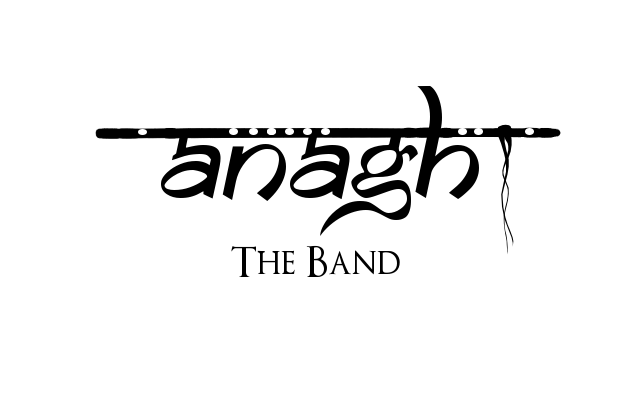

In [12]:
display.Image(IMAGE_PATH)

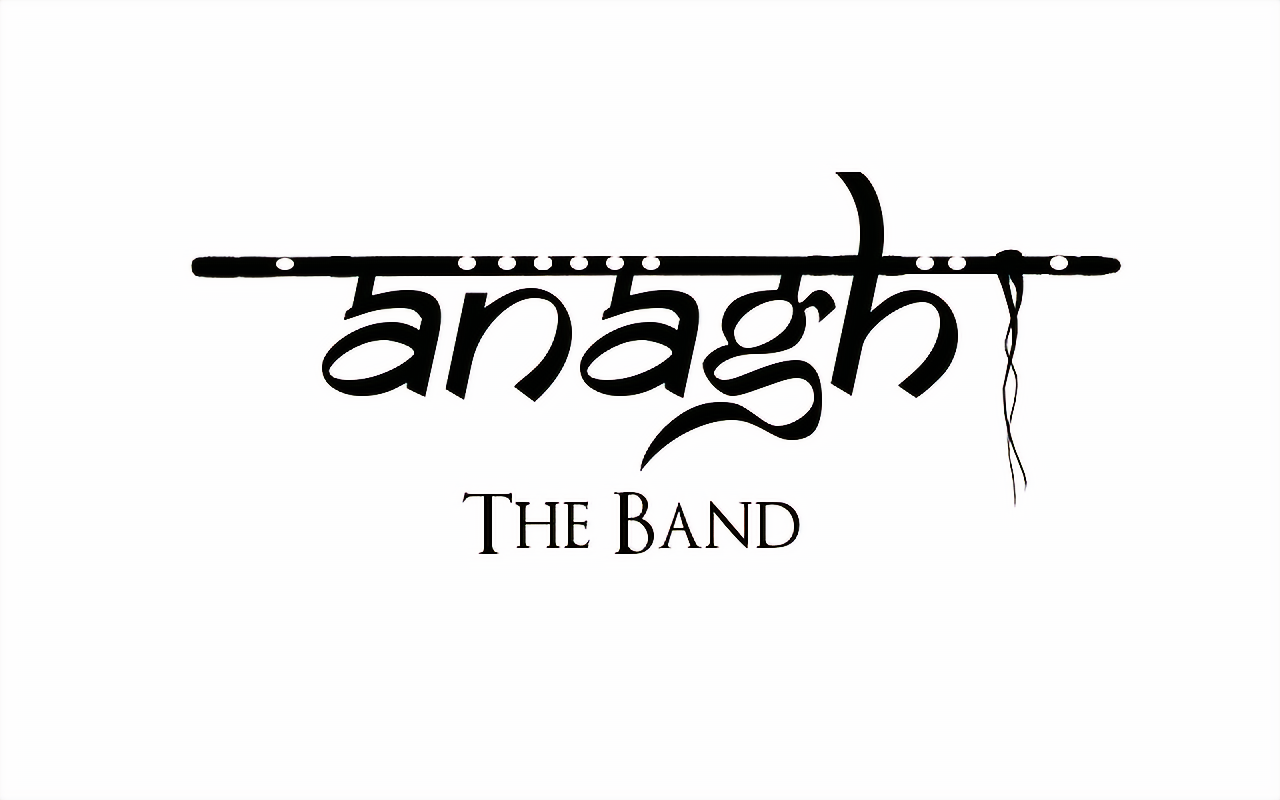

In [13]:
gen, path = generate(IMAGE_PATH)
display.Image(path)